## Model 3: XGBoost

In [9]:
# Import libraries
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Import data
df = pd.read_csv('train_for_models.csv')
df.head()

,amount_tsh,days_since_recorded,funder,gps_height,installer,basin,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,payment_type,water_quality,quantity,source,waterpoint_type,status_group
0,6000.0,995,other,1390,other,Lake Nyasa,109,True,VWC,False,1990s,gravity,annually,soft,enough,spring,communal standpipe,functional
1,0.0,272,other,1399,other,Lake Victoria,280,unknown,other,True,2010s,gravity,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional
2,25.0,281,other,686,other,Pangani,250,True,VWC,True,2000s,gravity,per bucket,soft,enough,dam,communal standpipe multiple,functional
3,0.0,309,unicef,263,other,Ruvuma / Southern Coast,58,True,VWC,True,1980s,submersible,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional
4,0.0,874,other,0,other,Lake Victoria,0,True,other,True,unknown,gravity,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional


In [3]:
target = df['status_group']
train_df = df.drop('status_group', axis=1, inplace=False)


In [4]:
train_df = pd.get_dummies(train_df)
train_df.head()

,amount_tsh,days_since_recorded,gps_height,population,funder_danida,funder_gov,funder_hesawa,funder_kkkt,funder_other,funder_rwssp,...,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,6000.0,995,1390,109,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
1,0.0,272,1399,280,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,25.0,281,686,250,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,309,263,58,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,874,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [5]:
scaler=StandardScaler()
scaled_features = scaler.fit_transform(train_df)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, target)

In [11]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy*100))
print("Validation Accuracy: {:.4%}".format(val_accuracy))

Training Accuracy: 74.47%
Validation Accuracy: 74.3704%


In [7]:
print(classification_report(y_test, val_preds))

                         precision    recall  f1-score   support

             functional       0.71      0.94      0.81      8039
functional needs repair       0.56      0.06      0.11      1075
         non functional       0.85      0.60      0.70      5736

               accuracy                           0.74     14850
              macro avg       0.70      0.53      0.54     14850
           weighted avg       0.75      0.74      0.72     14850



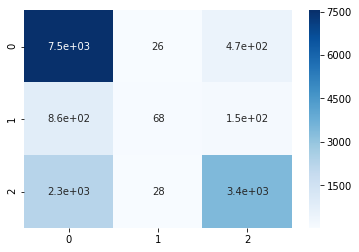

In [14]:
sns.heatmap(confusion_matrix(y_test, val_preds), annot=True, cmap='Blues')

## Using Gridsearch 

In [12]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [0.7],
    'n_estimators': [5, 30, 100, 250]
}

In [13]:
grid_clf = GridSearchCV(clf, param_grid)
grid_clf.fit(scaled_features, target)

best_parameters = grid_clf.best_params_

print("Grid Search found the optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))



Grid Search found the optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 250
subsample: 0.7


In [15]:
clf_2 = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 6, min_child_weight = 10, n_estimators = 250, subsample=0.7)
clf_2.fit(X_train, y_train)

clf_2_preds = clf_2.predict(X_test)

In [16]:
print(classification_report(y_test, clf_2_preds))

                         precision    recall  f1-score   support

             functional       0.76      0.92      0.83      8039
functional needs repair       0.66      0.23      0.34      1075
         non functional       0.85      0.71      0.77      5736

               accuracy                           0.79     14850
              macro avg       0.76      0.62      0.65     14850
           weighted avg       0.79      0.79      0.78     14850



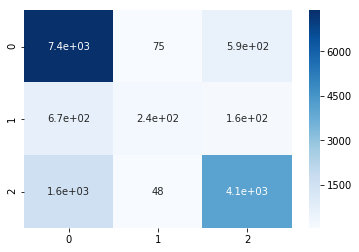

In [18]:
sns.heatmap(confusion_matrix(y_test, clf_2_preds), annot=True, cmap='Blues')